# Introduction

## Install Packages

In [ ]:
#On Anaconda Prompt:
#pip install tensorflow

In [ ]:
pip install plotly

In [ ]:
pip install requests_toolbelt

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [ ]:
pip install sklearn

In [ ]:
pip install imutils

In [ ]:
pip install opencv-python

In [ ]:
pip install fastparquet

In [ ]:
pip install pandavro

## Imports

In [1]:
from datetime import datetime, timedelta
import itertools
import json
import math
import os
import random
import shutil
import sys
import time
import requests
import joblib

In [2]:
from data.InstagramAPI.InstagramAPI import InstagramAPI

Fail to import moviepy. Need only for Video upload.


In [3]:
from imutils import paths #pip install opencv-python
from IPython.display import Image, display

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## Configs

In [4]:
TYPE = "dog"

DATE_BEGIN = datetime(2018,1,1,0,0).timestamp()

FINAL_CLASSES = ["desinte", "inte"]
#FINAL_CLASSES = ["m.desinte", "desinte", "inte", "m.inte"]
LEN_FINAL_CLASSES = len(FINAL_CLASSES)

PATH_BASE                        = os.getcwd()
PATH_BASE_DATA                   = os.path.join(PATH_BASE, "data")
PATH_1_CREATING_DATASET          = os.path.join(PATH_BASE_DATA, "1-Creating_Dataset")
PATH_FIRST_DATASET               = os.path.join(PATH_1_CREATING_DATASET, "Dataset")
PATH_FIRST_DATASET_TYPE          = os.path.join(PATH_FIRST_DATASET, TYPE)
PATH_FIRST_STATISTICS            = os.path.join(PATH_1_CREATING_DATASET, "Statistics")
PATH_FIRST_STATISTICS_TYPE       = os.path.join(PATH_FIRST_STATISTICS, TYPE)
PATH_2_PREPARING_DATASET         = os.path.join(PATH_BASE_DATA, "2-Preparing_Dataset")
PATH_CLEAN_DATASET               = os.path.join(PATH_2_PREPARING_DATASET, "Clean_Dataset")
PATH_CLEAN_DATASET_TYPE          = os.path.join(PATH_CLEAN_DATASET, TYPE)
PATH_CLEAN_STATISTICS            = os.path.join(PATH_2_PREPARING_DATASET, "Statistics")
PATH_CLEAN_STATISTICS_TYPE       = os.path.join(PATH_CLEAN_STATISTICS, TYPE)
PATH_3_PROCESSING_DATASET        = os.path.join(PATH_BASE_DATA, "3-Processing_Dataset")
PATH_SIMILARY_ACCOUNTS           = os.path.join(PATH_3_PROCESSING_DATASET, "Similary_Accounts")
PATH_SIMILARY_ACCOUNTS_TYPE      = os.path.join(PATH_SIMILARY_ACCOUNTS, TYPE)
PATH_LABEL_COUNTER               = os.path.join(PATH_3_PROCESSING_DATASET, "Label_Counter")
PATH_LABEL_COUNTER_TYPE          = os.path.join(PATH_LABEL_COUNTER, TYPE)
PATH_4_CLASSIFYING_DATASET       = os.path.join(PATH_BASE_DATA, "4-Classifying_Dataset")
PATH_FINAL_DATASET               = os.path.join(PATH_4_CLASSIFYING_DATASET, "Dataset")
PATH_FINAL_DATASET_TYPE          = os.path.join(PATH_FINAL_DATASET, TYPE)
PATH_FINAL_DATASET_TYPE_TRAIN    = os.path.join(PATH_FINAL_DATASET_TYPE, f"{LEN_FINAL_CLASSES}_classes", "Train")
PATH_FINAL_DATASET_TYPE_VALIDATE = os.path.join(PATH_FINAL_DATASET_TYPE, f"{LEN_FINAL_CLASSES}_classes", "Validate")
PATH_FINAL_DATASET_TYPE_TEST     = os.path.join(PATH_FINAL_DATASET_TYPE, f"{LEN_FINAL_CLASSES}_classes", "Test")

MIN_FOLLOWERS = 1000
MEDIA_TYPES = [1] #8
CANDIDATE = "N"
#CANDIDATE = -1
#CANDIDATE = 0
#CANDIDATE = 1
#CANDIDATE = 2

ONLY_WITH_COMMENTS = True

#CNN_MODEL_CLEAN = "VGG16"
#CNN_MODEL_CLEAN = "RESNET"
CNN_MODEL_CLEAN = "INCEPTIONV3"

#CLASSIFIER_CLEAN = "KNN"
#CLASSIFIER_CLEAN = "NB"
CLASSIFIER_CLEAN = "RANDOMFOREST"

PRINT_IMAGE_AND_PREDICTED_LABELS = False
DISPLAY_IMAGE_LABEL = f"non_{TYPE}"

FOLLOWERS_RADIUS = 5
LIKES_RADIUS = 95
TIMESTAMP_DIFFERENCE = 30 * 86400

RANDOMIZE_IF_EQUALS = True
#RANDOMIZE_IF_EQUALS = False

BATCH_SIZE = 24

#CNN_MODEL_FINAL = "VGG16"
CNN_MODEL_FINAL = "RESNET"
#CNN_MODEL_FINAL = "INCEPTIONV3"

#CLASSIFIER_FINAL = "KNN"
#CLASSIFIER_FINAL = "NB"
#CLASSIFIER_FINAL = "RANDOMFOREST"
CLASSIFIER_FINAL = "CNN"

EPOCHS = 20
CV = 5

print(f"DATE_BEGIN                       : {DATE_BEGIN}")
print(f"PATH_BASE                        : {PATH_BASE}")
print(f"PATH_BASE_DATA                   : {PATH_BASE_DATA}")
print(f"PATH_1_CREATING_DATASET          : {PATH_1_CREATING_DATASET}")
print(f"PATH_FIRST_DATASET               : {PATH_FIRST_DATASET}")
print(f"PATH_FIRST_DATASET_TYPE          : {PATH_FIRST_DATASET_TYPE}")
print(f"PATH_FIRST_STATISTICS            : {PATH_FIRST_STATISTICS}")
print(f"PATH_FIRST_STATISTICS_TYPE       : {PATH_FIRST_STATISTICS_TYPE}")
print(f"PATH_2_PREPARING_DATASET         : {PATH_2_PREPARING_DATASET}")
print(f"PATH_CLEAN_DATASET               : {PATH_CLEAN_DATASET}")
print(f"PATH_CLEAN_DATASET_TYPE          : {PATH_CLEAN_DATASET_TYPE}")
print(f"PATH_CLEAN_STATISTICS            : {PATH_CLEAN_STATISTICS}")
print(f"PATH_CLEAN_STATISTICS_TYPE       : {PATH_CLEAN_STATISTICS_TYPE}")
print(f"PATH_3_PROCESSING_DATASET        : {PATH_3_PROCESSING_DATASET}")
print(f"PATH_SIMILARY_ACCOUNTS           : {PATH_SIMILARY_ACCOUNTS}")
print(f"PATH_SIMILARY_ACCOUNTS_TYPE      : {PATH_SIMILARY_ACCOUNTS_TYPE}")
print(f"PATH_LABEL_COUNTER               : {PATH_LABEL_COUNTER}")
print(f"PATH_LABEL_COUNTER_TYPE          : {PATH_LABEL_COUNTER_TYPE}")
print(f"PATH_4_CLASSIFYING_DATASET       : {PATH_4_CLASSIFYING_DATASET}")
print(f"PATH_FINAL_DATASET               : {PATH_FINAL_DATASET}")
print(f"PATH_FINAL_DATASET_TYPE          : {PATH_FINAL_DATASET_TYPE}")
print(f"PATH_FINAL_DATASET_TYPE_TRAIN    : {PATH_FINAL_DATASET_TYPE_TRAIN}")
print(f"PATH_FINAL_DATASET_TYPE_VALIDATE : {PATH_FINAL_DATASET_TYPE_VALIDATE}")
print(f"PATH_FINAL_DATASET_TYPE_TEST     : {PATH_FINAL_DATASET_TYPE_TEST}")

DATE_BEGIN                       : 1514775600.0
PATH_BASE                        : D:\IC\tcc_insta
PATH_BASE_DATA                   : D:\IC\tcc_insta\data
PATH_1_CREATING_DATASET          : D:\IC\tcc_insta\data\1-Creating_Dataset
PATH_FIRST_DATASET               : D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset
PATH_FIRST_DATASET_TYPE          : D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\dog
PATH_FIRST_STATISTICS            : D:\IC\tcc_insta\data\1-Creating_Dataset\Statistics
PATH_FIRST_STATISTICS_TYPE       : D:\IC\tcc_insta\data\1-Creating_Dataset\Statistics\dog
PATH_2_PREPARING_DATASET         : D:\IC\tcc_insta\data\2-Preparing_Dataset
PATH_CLEAN_DATASET               : D:\IC\tcc_insta\data\2-Preparing_Dataset\Clean_Dataset
PATH_CLEAN_DATASET_TYPE          : D:\IC\tcc_insta\data\2-Preparing_Dataset\Clean_Dataset\dog
PATH_CLEAN_STATISTICS            : D:\IC\tcc_insta\data\2-Preparing_Dataset\Statistics
PATH_CLEAN_STATISTICS_TYPE       : D:\IC\tcc_insta\data\2-Preparing_Dataset\S

## Global Functions

In [5]:
def write_file(path_file, data, access_mode='a'):
    file = open(path_file, access_mode)
    if isinstance(data, list):
        for d in data:
            file.write(d)
    else:
        file.write(data)
    file.close()
    
def read_file(path_file, access_mode='r'):
    file = open(path_file, access_mode)
    data = file.readlines()
    file.close()  
    return data

def write_json(json_path, data, access_mode='w', encoding="utf-8"):
    with open(json_path, access_mode, encoding=encoding) as json_file:
        json.dump(data, json_file, indent=4, ensure_ascii=False)

def read_json(json_path, access_mode='r', encoding="utf-8"):
    with open(json_path, access_mode, encoding=encoding) as json_file:
        data = json.load(json_file)
    return data

##############################################

def get_accounts():
    list_accounts_file = read_file(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.txt"))
    list_accounts = []
    for acc_file in list_accounts_file:
        acc = acc_file.strip().lower()
        if acc[0] != "#":
            list_accounts.append(acc)
    return list_accounts

def log_print(data):
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {data}", flush=True)

def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
        log_print(f"Path '{path}' was created.")

def delete_path(path):
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)
        log_print(f"Path '{path}' was deleted.")

def random_sleep(min=0.1, max=3):
    time.sleep(round(random.uniform(min, max), 1))

##############################################

def remove_users_without_images(dataset_path, dataset_folder="Dataset", overview_file="user_posts_overview.json"):
    log_print(f"Beginning...")
    type_folder = os.path.join(dataset_path, dataset_folder, TYPE)
    for user_folder in next(os.walk(type_folder))[1]: #0 - root, 1 - dirs, 2 - files
        user_path = os.path.join(type_folder, user_folder)
        user_images_path = os.path.join(user_path, "images")
        try:
            posts_overview = read_json(os.path.join(user_path, overview_file))
            if (len(next(os.walk(user_images_path))[2]) == 0) or ("media_count_total" in posts_overview and posts_overview["media_count_total"] == 0) or ("image_count_total" in posts_overview and posts_overview["image_count_total"] == 0):
                log_print(user_folder)
                write_file(os.path.join(dataset_path, f"{TYPE}_users_error.log"), [f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - RemoveUsersWithoutImages - {user_folder}", "\n"])
        except Exception as e:
            log_print(f"ERROR: {user_folder} - {e}")
            write_file(os.path.join(dataset_path, f"{TYPE}_users_error.log"), [f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - RemoveUsersWithoutImages - {user_folder} - {e}", "\n"])
    log_print(f"Finished")  
        
def create_histogram(array, xlabel, ylabel, title, dataset_path, file_name, bins='auto', figsize=(7,6)):
    log_print(f"Creating {title} histogram...")
    h = plt.figure(figsize=figsize)
    n, bins, patches = plt.hist(array, bins=bins, edgecolor='black', linewidth=1)
    rotation = 65
    for i in range(len(bins)-1):
        if n[i] > 0:
            plt.text(bins[i]+((bins[i+1]-bins[i])/3), n[i]+(n[i]*0.02), str(math.ceil(n[i])), rotation=rotation)
    plt.grid(True)
    plt.xticks(bins, rotation=rotation)
    plt.style.use('seaborn-white')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(os.path.join(dataset_path, "Statistics", TYPE, file_name))
    log_print("Histogram created!")
            
def generate_statistics(dataset_path, dataset_folder="Dataset", overview_file="user_posts_overview.json"):
    list_accounts = get_accounts()
    df_statistics = pd.DataFrame()
    #total_count_media = 0
    log_print("Getting statistics...")
    
    array_likes = []
    array_comments = []
    array_likes_comments = []
    
    for acc in list_accounts:
        log_print(f"Executing account {acc}")
        user_file = read_json(os.path.join(dataset_path, dataset_folder, TYPE, acc, "user_info.json"))
        posts_overview = read_json(os.path.join(dataset_path, dataset_folder, TYPE, acc, overview_file))
        #total_count_media += posts_overview["media_count_total"]
        
        min_likes = posts_overview["items"][0]["like_count"]
        max_likes = posts_overview["items"][0]["like_count"]
        min_comments = posts_overview["items"][0]["comment_count"]
        max_comments = posts_overview["items"][0]["comment_count"]
        min_likes_comments = posts_overview["items"][0]["like_count"]
        max_likes_comments = posts_overview["items"][0]["like_count"]
        
        pk_min_likes = posts_overview["items"][0]["pk"]
        pk_max_likes = posts_overview["items"][0]["pk"]
        pk_min_comments = posts_overview["items"][0]["pk"]
        pk_max_comments = posts_overview["items"][0]["pk"]
        pk_min_likes_comments = posts_overview["items"][0]["pk"]
        pk_max_likes_comments = posts_overview["items"][0]["pk"]
        
        for item in posts_overview["items"]:
            
            array_likes.append(item["like_count"])
            array_comments.append(item["comment_count"])
            array_likes_comments.append(item["like_count"] + item["comment_count"])
            
            if item["like_count"] < min_likes:
                pk_min_likes = item["pk"]
                min_likes = item["like_count"]
            
            if item["like_count"] > max_likes:
                pk_max_likes = item["pk"]
                max_likes = item["like_count"]
            
            if item["comment_count"] < min_comments:
                pk_min_comments = item["pk"]
                min_comments = item["comment_count"]
            
            if item["comment_count"] > max_comments:
                pk_max_comments = item["pk"]
                max_comments = item["comment_count"]
                
            if item["like_count"] + item["comment_count"] < min_likes_comments:
                pk_min_likes_comments = item["pk"]
                min_likes_comments = item["like_count"] + item["comment_count"]
            
            if item["like_count"] + item["comment_count"] > max_likes_comments:
                pk_max_likes_comments = item["pk"]
                max_likes_comments = item["like_count"] + item["comment_count"]
        
        if "media_count_total" in posts_overview:
            media_count_total = int(math.ceil(posts_overview["media_count_total"]))
        else:
            media_count_total = int(math.ceil(posts_overview["image_count_total"]))
        
        new_row = {
            'user': acc,
            'followers_count': user_file["follower_count"],
            'media_count_total': media_count_total,
            'min_likes': int(math.ceil(min_likes)), 
            'max_likes': math.ceil(max_likes),
            'min_comments': math.ceil(min_comments),
            'max_comments': math.ceil(max_comments),
            'min_likes_comments': math.ceil(min_likes_comments),
            'max_likes_comments': math.ceil(max_likes_comments),
            'pk_min_likes': f"'{pk_min_likes}'",
            'pk_max_likes': f"'{pk_max_likes}'",
            'pk_min_comments': f"'{pk_min_comments}'",
            'pk_max_comments': f"'{pk_max_comments}'",
            'pk_min_likes_comments': f"'{pk_min_likes_comments}'",
            'pk_max_likes_comments': f"'{pk_max_likes_comments}'"
        }
        df_statistics = df_statistics.append(new_row, ignore_index=True)
    
    df_statistics = df_statistics.sort_values(by=['followers_count'], ascending=False)
    
    log_print("Finished")
    
    return {
        "df_statistics": df_statistics,
        "array_likes": array_likes,
        "array_comments": array_comments,
        "array_likes_comments": array_likes_comments
    }
    
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1 #IQR is interquartile range. 

    filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 *IQR)
    return df.loc[filter]

def generate_boxplots(df_statistics, dataset_path):
    file_name = "statistics_with_outliers.csv"
    log_print(f"Creating file {file_name}")
    df_statistics_with_outliers = df_statistics.copy()
    df_statistics_with_outliers.to_csv(os.path.join(dataset_path, "Statistics", TYPE, file_name), index=False)
    log_print(f"File {file_name} created!")

    file_name = "boxplot_with_outliers.png"
    log_print(f"Creating file {file_name}")
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.clf()
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df_statistics["followers_count"])
    ax.get_figure().savefig(os.path.join(dataset_path, "Statistics", TYPE, file_name))
    log_print(f"File {file_name} created!")
    
    file_name = "boxplot_without_outliers.png"
    log_print(f"Creating file {file_name}")
    plt.clf()
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df_statistics["followers_count"], showfliers=False)
    ax.get_figure().savefig(os.path.join(dataset_path, "Statistics", TYPE, file_name))
    log_print(f"File {file_name} created!")
    
    log_print("Removing outliers...")
    df_statistics = remove_outliers(df_statistics, "followers_count")
    df_statistics = df_statistics.sort_values(by=['followers_count'], ascending=False)
    
    file_name = "statistics_without_outliers.csv"
    log_print(f"Creating file {file_name}")
    df_statistics_without_outliers = df_statistics.copy()
    df_statistics_without_outliers.to_csv(os.path.join(dataset_path, "Statistics", TYPE, file_name), index=False)
    log_print(f"File {file_name} created!")
    
    return df_statistics
    
##############################################

def get_cnn_model(cnn_model_type):
    
    log_print(f"CNN_MODEL: {cnn_model_type}")
    log_print("Loading network...")
    
    if cnn_model_type == "VGG16":
        cnn_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
        target_size = (224, 224)
        final_shape = 7*7*512
        preprocess_func = tf.keras.applications.vgg16.preprocess_input
    elif cnn_model_type == "RESNET":
        cnn_model = tf.keras.applications.resnet.ResNet101(weights="imagenet", include_top=False)
        target_size = (224, 224)
        final_shape = 7*7*2048
        preprocess_func = tf.keras.applications.resnet.preprocess_input
    elif cnn_model_type == "INCEPTIONV3":
        cnn_model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False)
        target_size = (299, 299)
        final_shape = 8*8*2048
        preprocess_func = tf.keras.applications.inception_v3.preprocess_input
    else:
        log_print(f"INVALID CNN_MODEL: {cnn_model_type}")
        return None, (0,0), 0
    
    log_print("Network loaded.")
    return cnn_model, target_size, final_shape, preprocess_func
    
def get_classifier_model(classifier_model_type):
    
    log_print(f"CLASSIFIER: {classifier_model_type}")
    log_print("Loading model...")
    
    if classifier_model_type == "KNN":
        classifier_model = KNeighborsClassifier(n_neighbors=3)
    elif classifier_model_type == "NB":
        classifier_model = GaussianNB()
    elif classifier_model_type == "RANDOMFOREST":
        classifier_model = RandomForestClassifier()
    else:
        log_print(f"INVALID CLASSIFIER: {classifier_model_type}")
        return None
        
    log_print("Model loaded.")
    return classifier_model

def load_image_from_path(imagePath, target_size=(224, 224)):
    # load the input image using the Keras helper utility while ensuring the image is resized to 224x224 pixels
    image = load_img(imagePath, target_size=target_size)
    image = img_to_array(image)

    # preprocess the image by (1) expanding the dimensions and
    # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    return image

def loop_images_extract_features(model, target_size, final_shape, df_images, columns_names_with_labels, output_path=""):
    
    len_df_images = len(df_images)
    
    log_print("Loading all images...")
    df_images['image'] = df_images.apply(lambda row: load_image_from_path(row.imagePath, target_size), axis=1)

    log_print("Predicting...")
    features = model.predict(np.vstack(df_images.loc[:, "image"].copy().to_list()), batch_size=BATCH_SIZE, use_multiprocessing=True)      
    log_print(features.shape)
    features = features.reshape((features.shape[0], final_shape))

    df_images = df_images.drop(columns=["image", "imagePath"])
    
    log_print("Concatenating...")
    df_images = pd.concat([df_images, pd.DataFrame(features)], axis=1)

    log_print("Converting columns type...")
    df_images.columns = df_images.columns.astype(str)
    
    return df_images
    #log_print("Saving...")
    #pdx.to_avro(output_path, df_images)


##################################################

def error_log(acc, log_type, e):
    log_print(f"Failed to process {acc} account: {str(e)}")
    log_print(f"Appending to file {TYPE}_users_error.log")
    write_file(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users_error.log"), \
               [f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {log_type} - {acc} - {str(e)}", "\n"])
    print("**********************************************\n")

##################################################

def download_image(url, path):
    resp = requests.get(url, stream=True, timeout=20)  # Open the url image, set stream to True, this will return the stream content.
    local_file = open(path, 'wb')  # Open a local file with wb ( write binary ) permission.
    resp.raw.decode_content = True  # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    shutil.copyfileobj(resp.raw, local_file)  # Copy the response stream raw data to local image file.

print("OK.")

OK.


### Reset Type

In [ ]:
delete_path(PATH_FIRST_DATASET_TYPE)
delete_path(PATH_FIRST_STATISTICS_TYPE)
delete_path(PATH_CLEAN_DATASET_TYPE)
delete_path(PATH_SIMILARY_ACCOUNTS_TYPE)
delete_path(PATH_LABEL_COUNTER_TYPE)
delete_path(PATH_FINAL_DATASET_TYPE)

### Checking Folders

In [ ]:
#create_path(PATH_BASE_DATA)
#create_path(PATH_1_CREATING_DATASET)
#create_path(PATH_FIRST_DATASET)
create_path(PATH_FIRST_DATASET_TYPE)
#create_path(PATH_FIRST_STATISTICS)
create_path(PATH_FIRST_STATISTICS_TYPE)
#create_path(PATH_2_PREPARING_DATASET)
#create_path(PATH_CLEAN_DATASET)
create_path(PATH_CLEAN_DATASET_TYPE)
#create_path(PATH_CLEAN_STATISTICS)
create_path(PATH_CLEAN_STATISTICS_TYPE)
#create_path(PATH_3_PROCESSING_DATASET)
#create_path(PATH_SIMILARY_ACCOUNTS)
create_path(PATH_SIMILARY_ACCOUNTS_TYPE)
#create_path(PATH_LABEL_COUNTER)
create_path(PATH_LABEL_COUNTER_TYPE)
create_path(PATH_4_CLASSIFYING_DATASET)

#create_path(PATH_FINAL_DATASET_TYPE)
#create_path(PATH_FINAL_DATASET_TYPE_TRAIN)
#create_path(PATH_FINAL_DATASET_TYPE_TEST)
for classe in FINAL_CLASSES:
    create_path(os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, classe))
    create_path(os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, classe))
    create_path(os.path.join(PATH_FINAL_DATASET_TYPE_TEST, classe))

# Creating Dataset

## Getting Data

In [ ]:
file_logins = read_json(os.path.join(PATH_1_CREATING_DATASET, "logins.json"))
    
def next_login(id_login, len_logins):
    id_login += 1
    random_sleep()
    return id_login

def get_login(id_login=0, logins=file_logins["Logins"]):
    api = None
    logged = False
    while not logged:
        if not logins[id_login]["temporaly_blocked"]:
            log_print("Trying login in account: " + logins[id_login]["username"])
            api = InstagramAPI(logins[id_login]["username"], logins[id_login]["password"])
            logged = api.login()
            if not logged:
                id_login = next_login(id_login, len(logins))
        else:
            id_login = next_login(id_login, len(logins))
    return (api, id_login)

def get_from_api(api_function, api, id_login, params):

    aux_apilastjson = ""
    while True:
        
        if api_function == "searchUsername":
            api.searchUsername(params["acc"])
        elif api_function == "getUserFeed":
            if params["next_max_id"] == None:
                api.getUserFeed(params["user"]["pk"], minTimestamp=int(DATE_BEGIN))
            else:
                api.getUserFeed(params["user"]["pk"], maxid=params["next_max_id"], minTimestamp=int(DATE_BEGIN))

        log_print(f"{api_function}-status_code: {api.LastResponse.status_code}")
        if api.LastResponse.status_code == 560 or api.LastResponse.status_code == 500:
            log_print("Retry...")
            continue
        elif api.LastResponse.status_code == 429 or ('feedback_message' in api.LastJson and 'We restrict certain activity to protect our community. Based on your use, this action will be unavailable for you until' in api.LastJson["feedback_message"]) or ('message' in api.LastJson and api.LastJson["message"] == 'challenge_required'):
            (api, id_login) = get_login(id_login=id_login+1)
        elif api.LastResponse.status_code != 200:
            log_print(f"LastResponse: {api.LastResponse}")
            if aux_apilastjson != api.LastJson:
                log_print(f"LastJson: {api.LastJson}")
                raise Exception(f"{api.LastResponse.status_code}-{api.LastJson}")
            else:
                raise Exception(f"{api.LastResponse.status_code}")
        else:
            break
        
        aux_apilastjson = api.LastJson
        random_sleep()
    
    return (api, id_login)

def search_username(api, id_login, acc):
    log_print(f"Searching username {acc}")

    params = {}
    params["acc"] = acc
    (api, id_login) = get_from_api("searchUsername", api, id_login, params)
    
    return (api, id_login)

def create_file_user_info(api, id_login, acc):
    
    (api, id_login) = search_username(api, id_login, acc)
    
    imgs_user = {}
    imgs_user["user"] = acc
    imgs_user["downloaded"] = 0

    user = api.LastJson["user"]
    
    if user["follower_count"] >= MIN_FOLLOWERS:
        create_path(os.path.join(PATH_FIRST_DATASET_TYPE, acc))
        log_print("Creating file user_info")
        user["collected_at"] = datetime.timestamp(datetime.now())
        write_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_info.json"), user)
        log_print("File user_info created")
    else:
        raise Exception(f"User has fewer followers than {MIN_FOLLOWERS}")
    
    return (api, id_login, user,)

def get_user_feed(api, id_login, user, next_max_id=None):  
    
    params = {}
    params["next_max_id"] = next_max_id
    params["user"] = user
    (api, id_login) = get_from_api("getUserFeed", api, id_login, params)
    
    return (api, id_login)

def create_file_user_posts(api, id_login, user):
    log_print("Creating file user_posts")
    (api, id_login) = get_user_feed(api, id_login, user)
        
    posts = api.LastJson

    while (posts["more_available"]):
        random_sleep()
        aux_bool = False
        (api, id_login) = get_user_feed(api, id_login, user, posts["next_max_id"])

        posts["items"].extend(api.LastJson["items"])
        posts["num_results"] += api.LastJson["num_results"]
        posts["more_available"] =  api.LastJson["more_available"]
        if posts["more_available"]:
            posts["next_max_id"] = api.LastJson["next_max_id"]
        else:
            del posts['next_max_id']
        posts["auto_load_more_enabled"] = api.LastJson["auto_load_more_enabled"]
        posts["status"] = api.LastJson["status"]
        
    posts["collected_at"] = datetime.timestamp(datetime.now())
    if posts["num_results"] > 0:
        write_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts.json"), posts)
        log_print("File user_posts created")
    else:
        raise Exception(f"User has 0 posts")
    
    return (api, id_login, posts)

In [ ]:
if not os.path.exists(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.bkp")):
    shutil.copyfile(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.txt"), os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.bkp"))

(api, id_login) = get_login()

log_print("Type: " + TYPE)
log_print("Starting...\n")

list_accounts = get_accounts()
for acc in list_accounts:
    try:
        
        (api, id_login, user) = create_file_user_info(api, id_login, acc)
        (api, id_login, posts) = create_file_user_posts(api, id_login, user)
            
    except Exception as e:
        error_log(acc, "GettingData", e)
    else:
        log_print(f"Account {acc} successfully processed")
        print("**********************************************\n")

log_print("Finished")

## Creating Overview

In [ ]:
def get_candidate(post):
    if CANDIDATE != "N": 
        candidate_aux = CANDIDATE
        while (candidate_aux < 0 and abs(candidate_aux) > len(post["image_versions2"]["candidates"])) or \
            (candidate_aux >= 0 and candidate_aux >= len(post["image_versions2"]["candidates"])):
            if candidate_aux > 0:
                candidate_aux -= 1
            elif candidate_aux < 0:
                candidate_aux += 1
    else:
        candidate_aux = -1
        while post["image_versions2"]["candidates"][candidate_aux]["width"] < 500 or post["image_versions2"]["candidates"][candidate_aux]["height"] < 500:
            candidate_aux -= 1
            if abs(candidate_aux) > len(post["image_versions2"]["candidates"]):
                return None
    
    return candidate_aux

def create_file_user_posts_overview(posts):
    
    log_print("Creating file user_posts_overview")
    
    media_count_total = 0
    posts_overview = {}
    posts_overview["collected_at"] = posts["collected_at"]
    posts_overview["num_results"] = posts["num_results"]
    posts_overview["items"] = []
    
    for post in posts["items"]:
        if not post["media_type"] in MEDIA_TYPES:
            continue
        if ONLY_WITH_COMMENTS and "comments_disabled" in post:
            continue
            
        post_overview = {}
        post_overview["pk"] = post["pk"]
        post_overview["id"] = post["id"]
        post_overview["taken_at"] = post["taken_at"]
        post_overview["taken_at_year"] = datetime.fromtimestamp(post_overview["taken_at"]).year

        post_overview["caption_text"] = ""
        if not post["caption"] is None:
            post_overview["caption_text"] = post["caption"]["text"]

        post_overview["media_type"] = post["media_type"]
        post_overview["images"] = []
        if post_overview["media_type"] == 1:
            post_overview["media_count"] = 1
            
            candidate_aux = get_candidate(post)
            
            if candidate_aux == None:
                continue
            
            image = {}
            image["pk"] = post_overview["pk"]
            image["width"] = post["image_versions2"]["candidates"][candidate_aux]["width"]
            image["height"] = post["image_versions2"]["candidates"][candidate_aux]["height"]
            image["url"] = post["image_versions2"]["candidates"][candidate_aux]["url"]
            post_overview["images"].append(image)
        elif post_overview["media_type"] == 8:
            post_overview["media_count"] = post["carousel_media_count"]
            for carousel_post in post["carousel_media"]:
                
                candidate_aux = get_candidate(carousel_post)
                
                image = {}
                image["pk"] = carousel_post["pk"]
                image["width"] = carousel_post["image_versions2"]["candidates"][candidate_aux]["width"]
                image["height"] = carousel_post["image_versions2"]["candidates"][candidate_aux]["height"]
                image["url"] = carousel_post["image_versions2"]["candidates"][candidate_aux]["url"]
                post_overview["images"].append(image)

        media_count_total += post_overview["media_count"]
        
        post_overview["location"] = None
        if "location" in post:
            post_overview["location"] = post["location"]

        post_overview["like_count"] = post["like_count"]

        post_overview["comments_disabled"] = False
        if "comments_disabled" in post:
            post_overview["comments_disabled"] = post["comments_disabled"]
        if post_overview["comments_disabled"]:
            post_overview["comment_count"] = 0
        else:
            post_overview["comment_count"] = post["comment_count"]

        post_overview["like_comment_count"] = post_overview["like_count"] + post_overview["comment_count"]
            
        post_overview["caption_text_length"] = len(post_overview["caption_text"])
        hashtags = [word[1:] for word in post_overview["caption_text"].split() if word[0] == '#']
        post_overview["caption_hashtags_count"] = len(hashtags)
        post_overview["caption_hashtags"] = []
        
        if post_overview["caption_hashtags_count"] > 0:
            post_overview["caption_hashtags"] = hashtags
        post_overview["timestamp_duration"] = posts_overview["collected_at"] - post_overview["taken_at"]
        post_overview["likes_by_duration"] = post_overview["like_count"] / post_overview["timestamp_duration"]
        post_overview["comments_by_duration"] = post_overview["comment_count"] / post_overview["timestamp_duration"]

        posts_overview["items"].append(post_overview)
            
    posts_overview["media_count_total"] = media_count_total
    write_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"), posts_overview)
    log_print("File user_posts_overview created")

In [ ]:
list_accounts = get_accounts()
for acc in list_accounts:
    
    try:
        log_print(f"Processing account {acc}")

        posts = read_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts.json"))

        create_file_user_posts_overview(posts)

    except Exception as e:
        error_log(acc, "CreatingOverview", e)
    else:
        log_print(f"Account {acc} successfully processed")
        print("**********************************************\n")
        
log_print("Finished")

## Downloading Images

In [ ]:
again = True
while again:
    again = False
    list_accounts = get_accounts()
    for acc in list_accounts:

        try:
            log_print(f"Processing account {acc}")
            
            create_path(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images"))
                
            posts_overview = read_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"))

            log_print("Downloading posts pictures:")
            imgs_user_downloaded = len(list(next(os.walk(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images")))[2])) - 1 #0 - root, 1 - dirs, 2 - files
            if imgs_user_downloaded <= 0:
                imgs_user_downloaded = 0
            if imgs_user_downloaded < posts_overview['media_count_total']:
                for post in posts_overview["items"]:
                    for image in post["images"]:
                        if not os.path.exists(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg")):
                            download_image(image['url'], os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", f"{image['pk']}.jpg"))
                            imgs_user_downloaded += 1
                            log_print(f"{acc} - {imgs_user_downloaded}/{posts_overview['media_count_total']}")
                
            log_print(f"{imgs_user_downloaded} image(s) downloaded")
        except Exception as e:
            error_log(acc, "DownloadingImages", e)
            again = True
        else:
            log_print(f"Account {acc} successfully processed")
            print("**********************************************\n")
            
log_print("Finished")

## Statistics

### Remove Users Without Images

In [ ]:
remove_users_without_images(PATH_1_CREATING_DATASET, "Dataset", "user_posts_overview.json")

### Generate Statistics

In [ ]:
statistics = generate_statistics(PATH_1_CREATING_DATASET, "Dataset", "user_posts_overview.json")

In [ ]:
statistics = generate_boxplots(statistics["df_statistics"], PATH_1_CREATING_DATASET)
log_print("REMOVA OS USUÁRIOS DO TXT")

In [ ]:
statistics = generate_statistics(PATH_1_CREATING_DATASET, "Dataset", "user_posts_overview.json")

In [ ]:
create_histogram(statistics['df_statistics']['followers_count'].tolist(), "Seguidores", "Frequência", "Frequência de seguidores dos usuários", PATH_1_CREATING_DATASET, "histogram_followers_without_outliers.png")
create_histogram(statistics['array_likes'], "Curtidas", "Frequência", "Frequência de curtidas das imagens", PATH_1_CREATING_DATASET, "histogram_likes_without_outliers.png", 40, (18,6))
create_histogram(statistics['array_comments'], "Comentários", "Frequência", "Frequência de comentários das imagens", PATH_1_CREATING_DATASET, "histogram_comments_without_outliers.png", 40, (18,6))
create_histogram(statistics['array_likes_comments'], "Curtidas+Comentários", "Frequência", "Frequência de curtidas+comentários das imagens", PATH_1_CREATING_DATASET, "histogram_likes+comments_without_outliers.png", 40, (18,6))

# Preparing Dataset

## CNN Clean Configs

In [ ]:
PATH_CNN_CLEAN_BASE                       = os.path.join(PATH_2_PREPARING_DATASET, "CNN_Clean")
PATH_CNN_CLEAN_DATASET                    = os.path.join(PATH_CNN_CLEAN_BASE, "CNN_Dataset")
PATH_CNN_CLEAN_DATASET_TYPE               = os.path.join(PATH_CNN_CLEAN_DATASET, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN         = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Train")
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE    = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN, f"non_{TYPE}")
PATH_CNN_CLEAN_DATASET_TYPE_TEST          = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Test")
PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE     = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TEST, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE  = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TEST, f"non_{TYPE}")
PATH_CNN_CLEAN_OUTPUT                     = os.path.join(PATH_CNN_CLEAN_BASE, "CNN_Output")
PATH_CNN_CLEAN_OUTPUT_TYPE                = os.path.join(PATH_CNN_CLEAN_OUTPUT, TYPE)

print(f"PATH_CNN_CLEAN_BASE                      : {PATH_CNN_CLEAN_BASE}")
print(f"PATH_CNN_CLEAN_DATASET                   : {PATH_CNN_CLEAN_DATASET}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE              : {PATH_CNN_CLEAN_DATASET_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN        : {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE   : {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE: {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST         : {PATH_CNN_CLEAN_DATASET_TYPE_TEST}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE    : {PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE : {PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE}")
print(f"PATH_CNN_CLEAN_OUTPUT                    : {PATH_CNN_CLEAN_OUTPUT}")
print(f"PATH_CNN_CLEAN_OUTPUT_TYPE               : {PATH_CNN_CLEAN_OUTPUT_TYPE}")

### Reset Type

In [ ]:
delete_path(PATH_CNN_CLEAN_DATASET_TYPE)
delete_path(PATH_CNN_CLEAN_OUTPUT_TYPE)

### Checking Folders

In [ ]:
#create_path(PATH_CNN_CLEAN_BASE)
#create_path(PATH_CNN_CLEAN_DATASET)
#create_path(PATH_CNN_CLEAN_DATASET_TYPE)
#create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE)
#create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE)
#create_path(PATH_CNN_CLEAN_OUTPUT)
create_path(PATH_CNN_CLEAN_OUTPUT_TYPE)

## Renaming Images

In [ ]:
def rename_images(img_list, file_path, prefix):
    count = 0
    for img in img_list:
        os.rename(os.path.join(file_path, img), os.path.join(file_path, f"{prefix}_{count}.jpg"))
        count += 1
    
train_type_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE))[2] #0 - root, 1 - dirs, 2 - files
train_nontype_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE))[2] #0 - root, 1 - dirs, 2 - files
test_type_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE))[2] #0 - root, 1 - dirs, 2 - files
test_nontype_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE))[2] #0 - root, 1 - dirs, 2 - files

rename_images(train_type_images, PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE, 1)
rename_images(train_nontype_images, PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE, 0)
rename_images(test_type_images, PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE, 1)
rename_images(test_nontype_images, PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE, 0)

log_print("All images has been renamed")

## Extract Features

In [ ]:
le = LabelEncoder()
le.fit([f"non_{TYPE}", TYPE])
# serialize the label encoder to disk
joblib.dump(le, os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "le.pickle"))

In [ ]:
cnn_model, target_size, final_shape = get_cnn_model(CNN_MODEL_CLEAN)

In [ ]:
# loop over the data splits
#for split in (["Test", "Train"]):

log_print(f"Processing 'Train split'...")
p = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Train")
df_data = pd.DataFrame(list(paths.list_images(p)), columns=["imagePath"])
df_data['label'] = df_data.apply(lambda row: row.imagePath.split(os.path.sep)[-2], axis=1)
#output_path = os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Train_features.avro")
df_train = loop_images_extract_features(cnn_model, target_size, final_shape, df_data, ["label"], "label", "output_path")

log_print(f"=================================")

log_print(f"Processing 'Test split'...")
p = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Test")
df_data = pd.DataFrame(list(paths.list_images(p)), columns=["imagePath"])
df_data['label'] = df_data.apply(lambda row: row.imagePath.split(os.path.sep)[-2], axis=1)
#output_path = os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Test_features.avro")
df_test = loop_images_extract_features(cnn_model, target_size, final_shape, df_data, ["label"])

log_print("Finished")

## Train

### Load

In [ ]:
log_print("Loading Test dataset...")
df_test = pdx.read_avro(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Test_features.avro"))
#df_test = pd.read_parquet(path=os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Test_features"))
log_print("Test dataset loaded.")

log_print("Loading Train dataset...")
df_train = pdx.read_avro(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Train_features.avro"))
#df_train = pd.read_parquet(path=os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, f"{CNN_MODEL_CLEAN}_Train_features"))
log_print("Train dataset Loaded.")

In [ ]:
log_print("Loading labels...")
le = joblib.load(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "le.pickle"))
log_print("Labels loaded.")
print(le.classes_)

### Train

In [ ]:
log_print("Generating trainX, trainY...")
df_train = df_train.sample(frac=1).reset_index(drop=True)
trainX = df_train.copy().drop(columns=["label"]).to_numpy()
trainY = np.array(le.transform(df_train.loc[:,"label"].copy().tolist()))
df_train = None
log_print("trainX, trainY generated.")

log_print("Generating testX, testY...")
df_test = df_test.sample(frac=1).reset_index(drop=True)
testX = df_test.copy().drop(columns=["label"]).to_numpy()
testY = np.array(le.transform(df_test.loc[:,"label"].copy().tolist()))
df_test = None
log_print("testX, testY generated.")

In [ ]:
classifier_model = get_classifier_model(CLASSIFIER_CLEAN)

In [ ]:
log_print("Fit...")
classifier_model.fit(trainX, trainY)
log_print("Model trained.")

In [ ]:
log_print("Predict...")
predicted = classifier_model.predict(testX)
log_print("Predicted.")

In [ ]:
log_print(f"Confusion Matrix...")
print("")
conf_matrix = confusion_matrix(testY, predicted, labels=[le.transform([TYPE])[0], le.transform([f"non_{TYPE}"])[0]])
cmtx = pd.DataFrame(
    conf_matrix,
    index=[f'true: {TYPE}', f'true: non_{TYPE}'], 
    columns=[f'pred: {TYPE}', f'pred: non_{TYPE}']
)
print(cmtx)
print("")

log_print("Metrics:")
accuracy = accuracy_score(testY, predicted)
log_print("accuracy:    %.2f" % accuracy)

precision = precision_score(testY, predicted)
log_print("precision:   %.2f" % precision)

recall = recall_score(testY, predicted, pos_label=le.transform([TYPE])[0])
log_print("recall:      %.2f" % recall)

f1 = f1_score(testY, predicted)
log_print("f1:          %.2f" % f1)

print("")
log_print("Confusion Matrix Normalized...")
print("")
conf_matrix = confusion_matrix(testY, predicted, labels=[le.transform([TYPE])[0], le.transform([f"non_{TYPE}"])[0]], normalize='true')
cmtx = pd.DataFrame(
    conf_matrix,
    index=[f'true: {TYPE}', f'true: non_{TYPE}'], 
    columns=[f'pred: {TYPE}', f'pred: non_{TYPE}']
)
print(cmtx)

In [ ]:
log_print("Saving model...")
joblib.dump(classifier_model, os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "model.pickle"))

## Clean

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
testX = None
textY = None
trainX = None
trainY = None

In [ ]:
def process_image(row):
    retry = 1
    while retry <= 3:
        try:
            retry += 1
            img = load_img(row["path_image"], target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = imagenet_utils.preprocess_input(img)
            return img
        except Exception as e:
            log_print(f"Retrying ({retry}): Downloading {row['url']}")
            download_image(row["url"], row["path_image"])
    raise Exception(f"{row['path_image']}")

In [ ]:
le = joblib.load(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "le.pickle"))
model = joblib.load(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "model.pickle"))

list_accounts = get_accounts()

log_print("Loading network...")
vgg16 = tf.keras.applications.VGG16(weights="imagenet", include_top=False)

for acc in list_accounts:

    log_print(f"Processing account: {acc}")

    try:
    
        posts_overview = read_json(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"))
        if len(posts_overview["items"]) > 0:
            df_posts_overview = None
            df_posts_overview = pd.DataFrame(posts_overview["items"])
            df_posts_overview = df_posts_overview.apply(lambda x: [ (x["pk"], image["pk"], os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", f"{image['pk']}.jpg"), image["url"]) for image in x["images"]], axis=1)
            df_posts_overview = pd.DataFrame(list(itertools.chain.from_iterable(df_posts_overview.to_list())), columns=["pk_item", "pk_image", "path_image", "url"])

            tam = len(df_posts_overview.index)
            for offset in range(0, tam, BATCH_SIZE):
                log_print(f"Batch {round(((offset+1)/BATCH_SIZE)+0.5)}/{round((tam/BATCH_SIZE)+0.5)}")

                log_print("Creating image_values")
                df_posts_overview.loc[offset:offset+BATCH_SIZE,'image_values'] = df_posts_overview.apply(lambda row: process_image(row), axis=1)

                log_print("Predicting")
                batchImages = np.vstack(df_posts_overview.loc[offset:offset+BATCH_SIZE,'image_values'])
                features = vgg16.predict(batchImages, batch_size=BATCH_SIZE)
                features = features.reshape((features.shape[0], 7 * 7 * 512))
                resul = model.predict(features)
                df_posts_overview.loc[offset:offset+BATCH_SIZE,'predicted_label'] = resul

                if PRINT_IMAGE_AND_PREDICTED_LABELS:
                    log_print("Showing images and predicted labels:")
                    for index, row in df_posts_overview.loc[offset:offset+BATCH_SIZE].iterrows():
                        if DISPLAY_IMAGE_LABEL == "ALL" or DISPLAY_IMAGE_LABEL == le.classes_[int(row['predicted_label'])]:
                            display(Image(filename=row['path_image']))
                        log_print(f"Path: {row['path_image']}")
                        log_print(f"Label: {le.classes_[int(row['predicted_label'])]}") 
                    print("**********************************************\n")

            log_print("Creating user_posts_overview_clean.json") 

            posts_overview_clean = {}
            posts_overview_clean["collected_at"] = posts_overview["collected_at"]
            posts_overview_clean["item_count"] = 0
            posts_overview_clean["items"] = []
            posts_overview_clean["image_count_total"] = 0

            for index, row in df_posts_overview.iterrows():
                if le.classes_[int(row['predicted_label'])] == TYPE:
                    for item in posts_overview["items"]:
                        if row['pk_item'] == item["pk"]:
                            item_copy = item.copy()
                            item_copy["images"] = []
                            item_copy["image_count"] = 0

                            for image in item["images"]:
                                if row['pk_image'] == image["pk"]:
                                    item_copy["images"].append(image)
                                    item_copy["image_count"] += 1
                                    posts_overview_clean["image_count_total"] += 1
                                    break

                            if item_copy["image_count"] > 0:
                                posts_overview_clean["items"].append(item_copy)
                                posts_overview_clean["item_count"] += 1

                            break

            if posts_overview_clean["image_count_total"] > 0:
                create_path(os.path.join(PATH_CLEAN_DATASET_TYPE, acc))
                write_json(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_posts_overview_clean.json"), posts_overview_clean)
    except Exception as e:
        error_log(acc, "Cleaning", e)
    print("**********************************************\n")
log_print("Finished.")

## Moving Images

In [ ]:
list_accounts = get_accounts()

for acc in list_accounts:
    
    try:
        log_print(f"Processing account {acc}")

        shutil.copyfile(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_info.json"), os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_info.json"))

        create_path(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images"))

        overview_clean = read_json(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_posts_overview_clean.json"))

        images_moved = len(list(next(os.walk(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images")))[2])) - 1 #0 - root, 1 - dirs, 2 - files
        if images_moved <= 0:
            images_moved = 0
        for item in overview_clean["items"]:
            for image in item["images"]:
                if not os.path.exists(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg")):
                    shutil.move(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg"), os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg"))
                    images_moved += 1
                    log_print(f"{acc}: {images_moved}/{overview_clean['image_count_total']}") 
        print("**********************************************\n")
    except Exception as e:
        error_log(acc, "MovingImages", e)
            
log_print("Finished")

## Statistics

### Remove Users Without Images

In [ ]:
remove_users_without_images(PATH_2_PREPARING_DATASET, "Clean_Dataset", "user_posts_overview_clean.json")

### Generate Statistics

In [ ]:
statistics = generate_statistics(PATH_2_PREPARING_DATASET, "Clean_Dataset", "user_posts_overview_clean.json")

In [ ]:
statistics['df_statistics'].to_csv(os.path.join(PATH_2_PREPARING_DATASET, "Statistics", TYPE, "statistics_after_clean.csv"), index=False)

In [ ]:
create_histogram(statistics['df_statistics']['followers_count'].tolist(), "Seguidores", "Frequência", "Frequência de seguidores dos usuários após limpeza", PATH_2_PREPARING_DATASET, "histogram_followers_after_clean.png")
create_histogram(statistics['array_likes'], "Curtidas", "Frequência", "Frequência de curtidas das imagens após limpeza", PATH_2_PREPARING_DATASET, "histogram_likes_after_clean.png", 40, (18,6))
create_histogram(statistics['array_comments'], "Comentários", "Frequência", "Frequência de comentários das imagens após limpeza", PATH_2_PREPARING_DATASET, "histogram_comments_after_clean.png", 40, (18,6))
create_histogram(statistics['array_likes_comments'], "Curtidas+Comentários", "Frequência", "Frequência de curtidas+comentários das imagens após limpeza", PATH_2_PREPARING_DATASET, "histogram_likes+comments_after_clean.png", 40, (18,6))

# Processing Dataset

## Similary Accounts

In [ ]:
def get_users_comparison(i_followers, j_followers):
    if i_followers >= j_followers:
        diff_radius = i_followers * FOLLOWERS_RADIUS // 100
    else:
        diff_radius = j_followers * FOLLOWERS_RADIUS // 100

    diff_abs = abs(i_followers - j_followers)
    
    return { "comparison": diff_abs <= diff_radius,
           "diff_abs": diff_abs,
           "diff_radius": diff_radius }
    
def get_items_comparison(i_likes, j_likes):
    if i_likes >= j_likes:
        diff_radius = i_likes * LIKES_RADIUS // 100
    else:
        diff_radius = j_likes * LIKES_RADIUS // 100        
        
    diff_abs = abs(i_likes - j_likes)
    
    if diff_abs >= diff_radius:
        i_label = "igual"
        j_label = "igual"

        if i_likes > j_likes:
            i_label = "inte"
            j_label = "desinte"
        elif i_likes < j_likes:
            i_label = "desinte"
            j_label = "inte"
    else:
        i_label = None
        j_label = None
    
    return { "comparison": diff_abs >= diff_radius,
           "diff_abs": diff_abs,
           "diff_radius": diff_radius,
           "i_label": i_label,
           "j_label": j_label}
            

In [ ]:
list_accounts = get_accounts()
tam = len(list_accounts)

for i in range(tam-1):
    
    user_info_I = read_json(os.path.join(PATH_CLEAN_DATASET_TYPE, list_accounts[i], "user_info.json"))
        
    for j in range(i+1, tam):
        comparisons_list = []

        user_info_J = read_json(os.path.join(PATH_CLEAN_DATASET_TYPE, list_accounts[j], "user_info.json"))

        log_print(f"Comparando conta {i+1}-[{list_accounts[i]}] com conta {j+1}-[{list_accounts[j]}] / Total: {tam} contas.")

        users_comparison = get_users_comparison(user_info_I["follower_count"], user_info_I["follower_count"])
        if users_comparison["comparison"]:

            user_posts_overview_clean_I = read_json(os.path.join(PATH_CLEAN_DATASET_TYPE, list_accounts[i], "user_posts_overview_clean.json"))
            user_posts_overview_clean_J = read_json(os.path.join(PATH_CLEAN_DATASET_TYPE, list_accounts[j], "user_posts_overview_clean.json"))

            random.shuffle(user_posts_overview_clean_I["items"])
            random.shuffle(user_posts_overview_clean_J["items"])

            for item_I in user_posts_overview_clean_I["items"]:
                for item_J in user_posts_overview_clean_J["items"]:

                    if abs(item_I["taken_at"] - item_J["taken_at"]) <= TIMESTAMP_DIFFERENCE:          
                        items_comparison = get_items_comparison(item_I["like_count"], item_J["like_count"])
                        if (items_comparison["comparison"]):

                            row = {
                                 'type': TYPE,
                                 'i_username': list_accounts[i],
                                 'i_follower_count': user_info_I["follower_count"],
                                 'j_username': list_accounts[j],
                                 'j_follower_count': user_info_J["follower_count"],
                                 'diff_followers_abs': users_comparison["diff_abs"],
                                 'diff_followers_radius': users_comparison["diff_radius"],
                                 'i_pk': item_I["images"][0]["pk"],
                                 'i_like_count': item_I["like_count"],
                                 'j_pk': item_J["images"][0]["pk"],
                                 'j_like_count': item_J["like_count"],
                                 'diff_likes_abs': items_comparison["diff_abs"],
                                 'diff_likes_radius': items_comparison["diff_radius"],
                                 'i_label': items_comparison["i_label"],
                                 'j_label': items_comparison["j_label"]
                            }

                            comparisons_list.append(row)

            if len(comparisons_list) > 0:
                log_print(f"Saving {len(comparisons_list)} new rows")
                df = pd.DataFrame(comparisons_list)
                df.to_parquet(path=PATH_SIMILARY_ACCOUNTS_TYPE, partition_cols="i_username")

log_print("Finished")

## Label Counter

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
!echo 1 > /proc/sys/vm/overcommit_memory

### "inte" and "desinte" in label0

In [ ]:
df_similary_accounts = pd.read_parquet(path=PATH_SIMILARY_ACCOUNTS_TYPE)
print(f"Comparações: {df_similary_accounts.shape}")

In [ ]:
df_i = df_similary_accounts.loc[:, ["type", "i_username", "i_follower_count", "i_pk", "i_like_count", "i_label"]].copy()
df_j = df_similary_accounts.loc[:, ["type", "j_username", "j_follower_count", "j_pk", "j_like_count", "j_label"]].copy()

columns = ["type", "username", "follower_count", "pk", "like_count", "label"]
df_i.columns = columns
df_j.columns = columns

df_united = pd.concat([df_i, df_j], axis="index")
df_i = None
df_j = None

In [ ]:
df_similary_accounts = None

In [ ]:
df_united = df_united.groupby(columns).size().reset_index(name="count").sort_values(["pk","count"], ascending=[True, False]).copy()

In [ ]:
# AUXILIAR PARA ENCONTRAR PKS QUE RECEBERAM LABELS DIFERENTES EM DIFERENTES COMPARAÇÕES

log_print("Beginning...")
for i in df_united['pk'].tolist():
    if df_united[df_united["pk"]==i].count()["label"] > 1:
        log_print(i)
log_print("Finished")

In [ ]:
s = df_united.groupby(['type','username', 'follower_count', 'pk', 'like_count']).cumcount()

df_united = df_united.set_index(['type','username', 'follower_count', 'pk', 'like_count', s]).unstack().sort_index(level=1, axis=1)
df_united.columns = [f'{x}{y}' for x, y in df_united.columns]
df_united = df_united.reset_index()

In [ ]:
df_united[df_united["label0"] == "igual"]

In [ ]:
# SE EXISTIR ALGUM IGUAL

if RANDOM_IGUAL:
    df_label_counter = df_united.copy()
    df_label_counter.loc[df_label_counter['label0'] == 'igual', 'label'] = [ random.choice(["inte", "desinte"]) for k in df_label_counter.loc[df_label_counter['label0'] == 'igual'].index ]
else:
    df_label_counter = df_label_counter_aux.loc[df_label_counter['label'] != 'igual'].copy()

df_united = df_label_counter

### Generating labelB with "m. inte", "inte", "desinte" and "m. desinte"

In [ ]:
mediana_inte = df_united[df_united["label0"] == "inte"]["count0"].median()
mediana_desinte = df_united[df_united["label0"] == "desinte"]["count0"].median()
print(f"mediana_inte: {mediana_inte}")
print(f"mediana_desinte: {mediana_desinte}")

In [ ]:
df_united.loc[(df_united['label0'] == "inte") & (df_united['count0'] >= mediana_inte), 'labelB'] = "m.inte"
df_united.loc[(df_united['label0'] == "inte") & (df_united['count0'] <  mediana_inte), 'labelB'] = "inte"
df_united.loc[(df_united['label0'] == "desinte") & (df_united['count0'] <  mediana_desinte), 'labelB'] = "desinte"
df_united.loc[(df_united['label0'] == "desinte") & (df_united['count0'] >= mediana_desinte), 'labelB'] = "m.desinte"

In [ ]:
print(f"Total: {df_united.shape}")
print("==========================================================")
print(f'inte      = {df_united.loc[df_united["label0"] == "inte"].shape}')
print(f'desinte   = {df_united.loc[df_united["label0"] == "desinte"].shape}')
print("==========================================================")
print(f'm.inte    = {df_united.loc[df_united["labelB"] == "m.inte"].shape}')
print(f'inte      = {df_united.loc[df_united["labelB"] == "inte"].shape}')
print(f'desinte   = {df_united.loc[df_united["labelB"] == "desinte"].shape}')
print(f'm.desinte = {df_united.loc[df_united["labelB"] == "m.desinte"].shape}')

In [ ]:
df_united.to_parquet(path=PATH_LABEL_COUNTER_TYPE, partition_cols="labelB")

In [6]:
df_united = pd.read_parquet(path=PATH_LABEL_COUNTER_TYPE)

In [7]:
df_united

,type,username,follower_count,pk,like_count,count0,label0,count1,label1,labelB
0,dog,angelcitypits,102652,1682816890790998168,633,172.0,desinte,NaN,None,desinte
1,dog,angelcitypits,102652,1682912627256055971,504,230.0,desinte,NaN,None,desinte
2,dog,angelcitypits,102652,1684197133912914639,740,148.0,desinte,NaN,None,desinte
3,dog,angelcitypits,102652,1687147453500817740,552,249.0,desinte,NaN,None,desinte
4,dog,angelcitypits,102652,1690346110807014929,574,257.0,desinte,NaN,None,desinte
...,...,...,...,...,...,...,...,...,...,...
30534,dog,wontonsoup_the_peke,51976,1723686093663325267,8384,396.0,inte,NaN,None,m.inte
30535,dog,wontonsoup_the_peke,51976,1875828243887831889,6262,350.0,inte,NaN,None,m.inte
30536,dog,wontonsoup_the_peke,51976,1902686547272364909,5218,326.0,inte,NaN,None,m.inte
30537,dog,wontonsoup_the_peke,51976,1949084813865838810,13496,580.0,inte,NaN,None,m.inte


      type     username  follower_count                   pk  like_count  \
24763  dog  dailydougie          517654  1904069860791824881        6758   

       count0 label0  count1 label1  labelB  
24763   459.0   inte     NaN   None  m.inte  


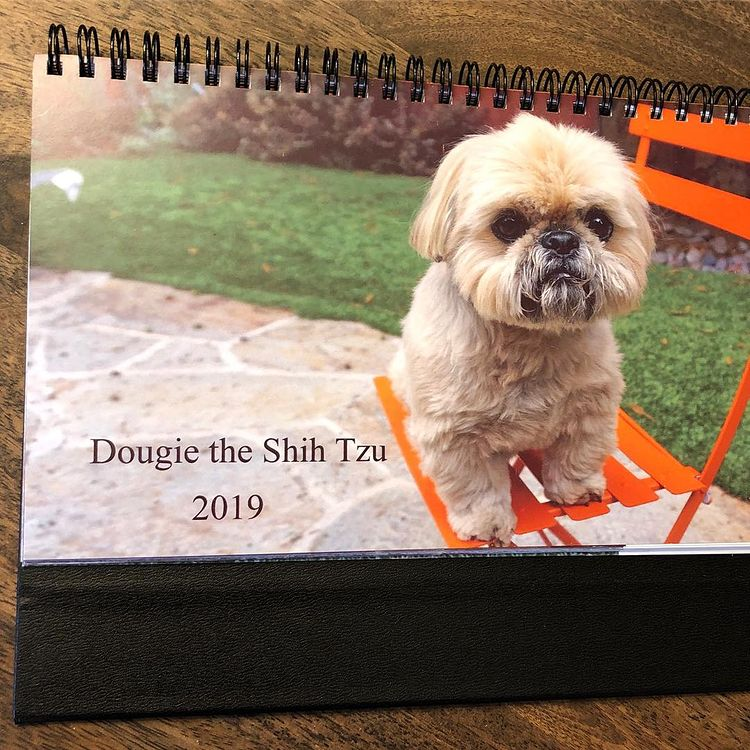

In [8]:
minte_ex = df_united[df_united["labelB"] == "m.inte"].sample()
print(minte_ex)
display(Image(filename=os.path.join(PATH_CLEAN_DATASET_TYPE, minte_ex.iloc[0]['username'], 'images', str(minte_ex.iloc[0]['pk']) + ".jpg")))

     type         username  follower_count                   pk  like_count  \
8594  dog  brussels.sprout          177779  1836337124463606650        5145   

      count0 label0  count1 label1 labelB  
8594   182.0   inte     NaN   None   inte  


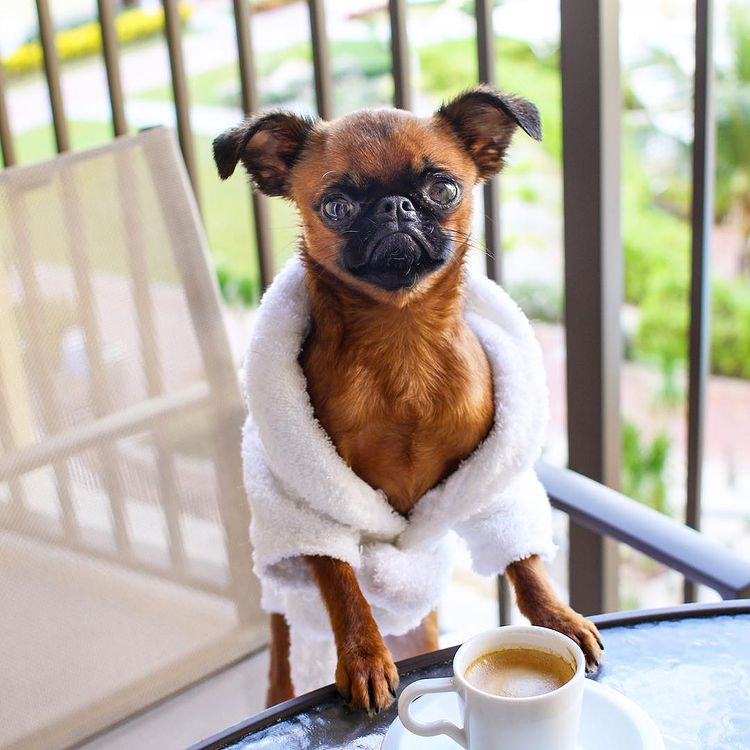

In [9]:
inte_ex = df_united[df_united["labelB"] == "inte"].sample()
print(inte_ex)
display(Image(filename=os.path.join(PATH_CLEAN_DATASET_TYPE, inte_ex.iloc[0]['username'], 'images', str(inte_ex.iloc[0]['pk']) + ".jpg")))

     type          username  follower_count                   pk  like_count  \
4444  dog  newyorkbullycrew          279170  1684119866830129449        1880   

      count0   label0  count1 label1   labelB  
4444    22.0  desinte     6.0   inte  desinte  


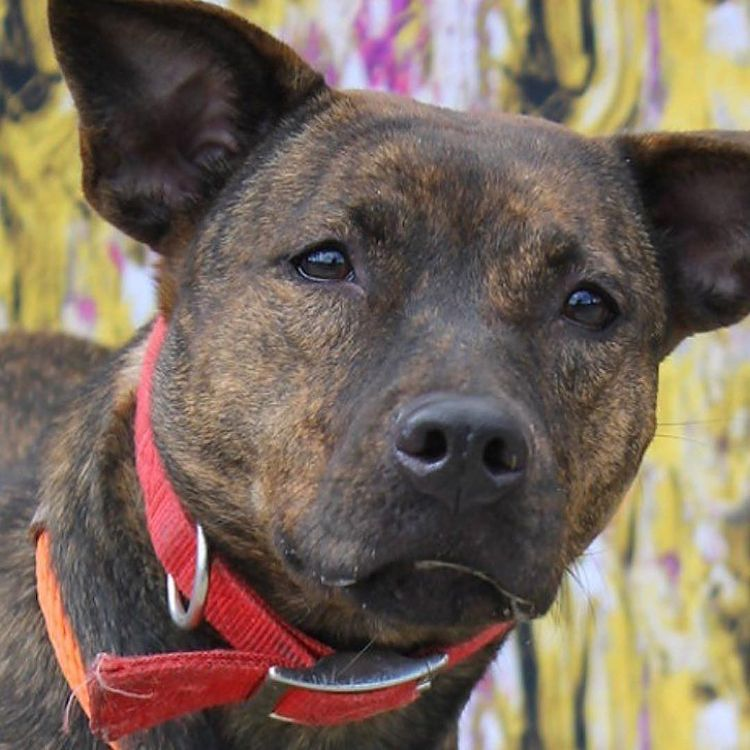

In [27]:
desinte_ex = df_united[df_united["labelB"] == "desinte"].sample()
print(desinte_ex)
display(Image(filename=os.path.join(PATH_CLEAN_DATASET_TYPE, desinte_ex.iloc[0]['username'], 'images', str(desinte_ex.iloc[0]['pk']) + ".jpg")))

      type         username  follower_count                   pk  like_count  \
17874  dog  dallaspetsalive           17147  2207640092393458676          91   

       count0   label0  count1 label1     labelB  
17874   615.0  desinte     NaN   None  m.desinte  


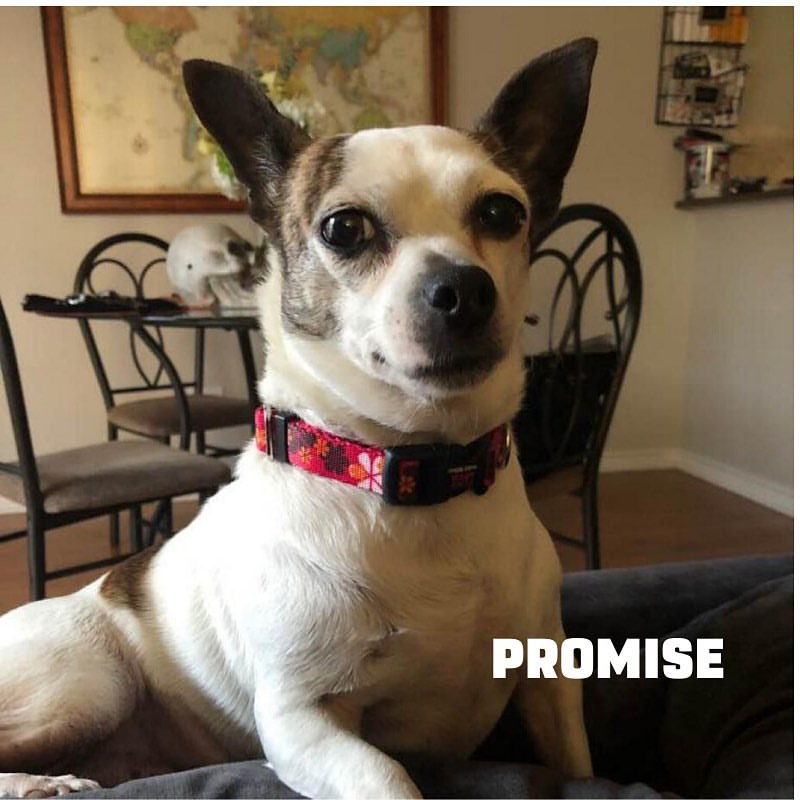

In [14]:
mdesinte_ex = df_united[df_united["labelB"] == "m.desinte"].sample()
print(mdesinte_ex)
display(Image(filename=os.path.join(PATH_CLEAN_DATASET_TYPE, mdesinte_ex.iloc[0]['username'], 'images', str(mdesinte_ex.iloc[0]['pk']) + ".jpg")))

### Final Dataset

In [ ]:
df_images = pd.read_parquet(path=PATH_LABEL_COUNTER_TYPE)

In [ ]:
if CLASSIFIER_FINAL != "CNN":
    n_images = 1000
elif LEN_FINAL_CLASSES == 2:
    n_images = 3000
elif LEN_FINAL_CLASSES == 4:
    n_images = 1500
print(f"n_images: {n_images}")

In [ ]:
df_minte = df_images.loc[df_images["labelB"] == "m.inte"].sort_values(by='count0', ascending=False).iloc[0:n_images].reset_index(drop=True)
df_inte = df_images.loc[df_images["labelB"] == "inte"].sort_values(by='count0', ascending=False).iloc[0:n_images].reset_index(drop=True)
df_desinte = df_images.loc[df_images["labelB"] == "desinte"].sort_values(by='count0', ascending=False).iloc[0:n_images].reset_index(drop=True)
df_mdesinte = df_images.loc[df_images["labelB"] == "m.desinte"].sort_values(by='count0', ascending=False).iloc[0:n_images].reset_index(drop=True)

In [ ]:
df_minte

In [ ]:
df_inte

In [ ]:
df_desinte

In [ ]:
df_mdesinte

In [ ]:
df_images = pd.concat([df_minte,df_inte,df_desinte,df_mdesinte]).sample(frac=1).reset_index(drop=True)

In [ ]:
if CLASSIFIER_FINAL != "CNN":
    df_images.to_csv(path_or_buf=os.path.join(PATH_FINAL_DATASET_TYPE,f"{LEN_FINAL_CLASSES}_classes_CLASSIFIER_dataset.csv"), index=False)
else:
    df_images.to_csv(path_or_buf=os.path.join(PATH_FINAL_DATASET_TYPE,f"{LEN_FINAL_CLASSES}_classes_CNN_dataset.csv"), index=False)

# Classifying Dataset

## CNN Classify Configs

In [ ]:
PATH_CNN_CLASSIFY_BASE                  = os.path.join(PATH_4_CLASSIFYING_DATASET, "CNN_Classify")
PATH_CNN_CLASSIFY_OUTPUT                = os.path.join(PATH_CNN_CLASSIFY_BASE, "CNN_Output")
PATH_CNN_CLASSIFY_OUTPUT_TYPE           = os.path.join(PATH_CNN_CLASSIFY_OUTPUT, TYPE)
PATH_CNN_CLASSIFY_OUTPUT_TYPE_TEST_LISA = os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, "Test")

print(f"PATH_CNN_CLASSIFY_BASE                 : {PATH_CNN_CLASSIFY_BASE}")
print(f"PATH_CNN_CLASSIFY_OUTPUT               : {PATH_CNN_CLASSIFY_OUTPUT}")
print(f"PATH_CNN_CLASSIFY_OUTPUT_TYPE          : {PATH_CNN_CLASSIFY_OUTPUT_TYPE}")
print(f"PATH_CNN_CLASSIFY_OUTPUT_TYPE_TEST_LISA: {PATH_CNN_CLASSIFY_OUTPUT_TYPE_TEST_LISA}")

### Reset Type

In [ ]:
delete_path(PATH_CNN_CLASSIFY_OUTPUT_TYPE)

### Checking Folders

In [ ]:
#create_path(PATH_CNN_CLASSIFY_BASE)
#create_path(PATH_CNN_CLASSIFY_OUTPUT)
#create_path(PATH_CNN_CLASSIFY_OUTPUT_TYPE)
create_path(PATH_CNN_CLASSIFY_OUTPUT_TYPE_TEST_LISA)

## Begin

In [ ]:
le = LabelEncoder()
le.fit(FINAL_CLASSES)
# serialize the label encoder to disk
joblib.dump(le, os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"le_{LEN_FINAL_CLASSES}_classes.pickle"))

In [ ]:
log_print("Reading...")
if CLASSIFIER_FINAL != "CNN":
    df_images = pd.read_csv(filepath_or_buffer=os.path.join(PATH_FINAL_DATASET_TYPE, f"{LEN_FINAL_CLASSES}_classes_CLASSIFIER_dataset.csv"))
else:
    df_images = pd.read_csv(filepath_or_buffer=os.path.join(PATH_FINAL_DATASET_TYPE, f"{LEN_FINAL_CLASSES}_classes_CNN_dataset.csv"))
log_print("Finished.")

In [ ]:
df_images['imagePath'] = df_images.apply(lambda row: os.path.join(PATH_CLEAN_DATASET_TYPE, row.username, 'images', str(row.pk) + '.jpg'), axis=1)

df_images = df_images.loc[:, ['imagePath', 'label0', 'labelB']].copy()
df_images = df_images.sample(frac=1).reset_index(drop=True)

## CNN Final com Classificadores

### Extract Features

In [ ]:
cnn_model, target_size, final_shape, preprocess_func = get_cnn_model(CNN_MODEL_FINAL)

In [ ]:
log_print("Extracting features...")
df_images = loop_images_extract_features(cnn_model, target_size, final_shape, df_images, ["label0", "labelB"])
log_print("Finished.")

### CNN Final com Classificadores - Train com Cross-Validation

In [ ]:
X = df_images.copy().drop(columns=["label0", "labelB"]).to_numpy()

if LEN_FINAL_CLASSES == 2:
    y = np.array(le.transform(df_images.loc[:,"label0"].copy().tolist()))
elif LEN_FINAL_CLASSES == 4:
    y = np.array(le.transform(df_images.loc[:,"labelB"].copy().tolist()))

In [ ]:
classifier_model = get_classifier_model(CLASSIFIER_FINAL)

In [ ]:
metrics_result = {}
metrics_result["model"] = []
metrics_result["accuracy_score"] = []
metrics_result["precision_score"] = []
metrics_result["recall_score"] = []
metrics_result["f1_score"] = []
metrics_result["confusion_matrix"] = []
metrics_result["confusion_matrix_normalized"] = []

log_print(f"Iniciando cross validation p/ {CV} folds...")
kf = KFold(n_splits=CV)
kf.get_n_splits(X)

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1  
    print("")
    log_print(f"=========== FOLD - {fold} ===========")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    log_print("Fit...")
    classifier_model.fit(X_train, y_train)
    
    log_print("Predict...")
    predicted = classifier_model.predict(X_test)
    
    metrics_result["model"].append(classifier_model)
    
    #print(f"predicted: {predicted}")
    #print(f"y_test:    {y_test}")
    
    print("")
    log_print(f"Confusion Matrix...")
    print("")
    if LEN_FINAL_CLASSES == 2:
        conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["inte"])[0], le.transform(["desinte"])[0]])

        cmtx = pd.DataFrame(
            conf_matrix,
            index=['true: inte', 'true: desinte'], 
            columns=['pred: inte', 'pred: desinte']
        )
    elif LEN_FINAL_CLASSES == 4:
        conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["m.inte"])[0], le.transform(["inte"])[0], le.transform(["desinte"])[0], le.transform(["m.desinte"])[0]])

        cmtx = pd.DataFrame(
            conf_matrix,
            index=['true: m.inte', 'true: inte', 'true: desinte', 'true: m.desinte'], 
            columns=['pred: m.inte', 'pred: inte', 'pred: desinte', 'pred: m.desinte']
        )
    print(cmtx)
    print("")
    metrics_result["confusion_matrix"].append(conf_matrix)

    log_print("Metrics:")
    accuracy = accuracy_score(y_test, predicted)
    metrics_result["accuracy_score"].append(accuracy)
    log_print("accuracy:    %.2f" % accuracy)
    
    if LEN_FINAL_CLASSES == 2:
        precision = precision_score(y_test, predicted)
    elif LEN_FINAL_CLASSES == 4:
        precision = precision_score(y_test, predicted, average="macro")
    metrics_result["precision_score"].append(precision)
    log_print("precision:   %.2f" % precision)
    
    if LEN_FINAL_CLASSES == 2:
        recall = recall_score(y_test, predicted, pos_label=le.transform(["inte"])[0])
    elif LEN_FINAL_CLASSES == 4:
        recall = recall_score(y_test, predicted, average="macro")
    metrics_result["recall_score"].append(recall)
    log_print("recall:      %.2f" % recall)
    
    if LEN_FINAL_CLASSES == 2:
        f1 = f1_score(y_test, predicted)
    elif LEN_FINAL_CLASSES == 4:
        f1 = f1_score(y_test, predicted, average="macro")
    metrics_result["f1_score"].append(f1)
    log_print("f1:          %.2f" % f1)
    
    print("")
    log_print("Confusion Matrix Normalized...")
    print("")
    if LEN_FINAL_CLASSES == 2:
        conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["inte"])[0], le.transform(["desinte"])[0]], normalize='true')
        cmtx = pd.DataFrame(
            conf_matrix,
            index=['true: inte', 'true: desinte'], 
            columns=['pred: inte', 'pred: desinte']
        )
    elif LEN_FINAL_CLASSES == 4:
        conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["m.inte"])[0], le.transform(["inte"])[0], le.transform(["desinte"])[0], le.transform(["m.desinte"])[0]], normalize='true')
        cmtx = pd.DataFrame(
            conf_matrix,
            index=['true: m.inte', 'true: inte', 'true: desinte', 'true: m.desinte'], 
            columns=['pred: m.inte', 'pred: inte', 'pred: desinte', 'pred: m.desinte']
        )
    print(cmtx)
    print("")
    metrics_result["confusion_matrix_normalized"].append(conf_matrix)

print("")
log_print("Finished")

In [ ]:
log_print(f'accuracy: {np.array(metrics_result["accuracy_score"]).mean()} +- {np.array(metrics_result["accuracy_score"]).std()}')
log_print(f'precision: {np.array(metrics_result["precision_score"]).mean()} +- {np.array(metrics_result["precision_score"]).std()}')
log_print(f'recall: {np.array(metrics_result["recall_score"]).mean()} +- {np.array(metrics_result["recall_score"]).std()}')
log_print(f'f1: {np.array(metrics_result["f1_score"]).mean()} +- {np.array(metrics_result["f1_score"]).std()}')

In [ ]:
if LEN_FINAL_CLASSES == 2:
    cm_00 = []
    cm_01 = []
    cm_10 = []
    cm_11 = []

    for cm in metrics_result["confusion_matrix_normalized"]:
        cm_00.append(cm[0][0])
        cm_01.append(cm[0][1])
        cm_10.append(cm[1][0])
        cm_11.append(cm[1][1])

    log_print(f'00: {np.array(cm_00).mean()} +- {np.array(cm_00).std()}')
    log_print(f'01: {np.array(cm_01).mean()} +- {np.array(cm_01).std()}')
    log_print(f'10: {np.array(cm_10).mean()} +- {np.array(cm_10).std()}')
    log_print(f'11: {np.array(cm_11).mean()} +- {np.array(cm_11).std()}')
    
elif LEN_FINAL_CLASSES == 4:
    cm_00 = []
    cm_01 = []
    cm_02 = []
    cm_03 = []
    cm_10 = []
    cm_11 = []
    cm_12 = []
    cm_13 = []
    cm_20 = []
    cm_21 = []
    cm_22 = []
    cm_23 = []
    cm_30 = []
    cm_31 = []
    cm_32 = []
    cm_33 = []

    for cm in metrics_result["confusion_matrix_normalized"]:
        cm_00.append(cm[0][0])
        cm_01.append(cm[0][1])
        cm_02.append(cm[0][2])
        cm_03.append(cm[0][3])
        cm_10.append(cm[1][0])
        cm_11.append(cm[1][1])
        cm_12.append(cm[1][2])
        cm_13.append(cm[1][3])
        cm_20.append(cm[2][0])
        cm_21.append(cm[2][1])
        cm_22.append(cm[2][2])
        cm_23.append(cm[2][3])
        cm_30.append(cm[3][0])
        cm_31.append(cm[3][1])
        cm_32.append(cm[3][2])
        cm_33.append(cm[3][3])

    log_print(f'00: {np.array(cm_00).mean()} +- {np.array(cm_00).std()}')
    log_print(f'01: {np.array(cm_01).mean()} +- {np.array(cm_01).std()}')
    log_print(f'02: {np.array(cm_02).mean()} +- {np.array(cm_02).std()}')
    log_print(f'03: {np.array(cm_03).mean()} +- {np.array(cm_03).std()}')
    log_print(f'10: {np.array(cm_10).mean()} +- {np.array(cm_10).std()}')
    log_print(f'11: {np.array(cm_11).mean()} +- {np.array(cm_11).std()}')
    log_print(f'12: {np.array(cm_12).mean()} +- {np.array(cm_12).std()}')
    log_print(f'13: {np.array(cm_13).mean()} +- {np.array(cm_13).std()}')
    log_print(f'20: {np.array(cm_20).mean()} +- {np.array(cm_20).std()}')
    log_print(f'21: {np.array(cm_21).mean()} +- {np.array(cm_21).std()}')
    log_print(f'22: {np.array(cm_22).mean()} +- {np.array(cm_22).std()}')
    log_print(f'23: {np.array(cm_23).mean()} +- {np.array(cm_23).std()}')
    log_print(f'30: {np.array(cm_30).mean()} +- {np.array(cm_30).std()}')
    log_print(f'31: {np.array(cm_31).mean()} +- {np.array(cm_31).std()}')
    log_print(f'32: {np.array(cm_32).mean()} +- {np.array(cm_32).std()}')
    log_print(f'33: {np.array(cm_33).mean()} +- {np.array(cm_33).std()}')

In [ ]:
# Salvando
joblib.dump(classifier_model, os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE,f"model_{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_{CLASSIFIER_FINAL}.pickle"))

## CNN apenas

### Split Train/Test and Copy Images

In [ ]:
df_minte_aux = train_test_split(df_images[df_images["labelB"] == "m.inte"], test_size=0.3, shuffle=True)
df_inte_aux = train_test_split(df_images[df_images["labelB"] == "inte"], test_size=0.3, shuffle=True)
df_desinte_aux = train_test_split(df_images[df_images["labelB"] == "desinte"], test_size=0.3, shuffle=True)
df_mdesinte_aux = train_test_split(df_images[df_images["labelB"] == "m.desinte"], test_size=0.3, shuffle=True)

df_minte_train = df_minte_aux[0]
df_inte_train = df_inte_aux[0]
df_desinte_train = df_desinte_aux[0]
df_mdesinte_train = df_mdesinte_aux[0]

df_minte_aux = train_test_split(df_minte_aux[1], test_size=1/3, shuffle=True)
df_inte_aux = train_test_split(df_inte_aux[1], test_size=1/3, shuffle=True)
df_desinte_aux = train_test_split(df_desinte_aux[1], test_size=1/3, shuffle=True)
df_mdesinte_aux = train_test_split(df_mdesinte_aux[1], test_size=1/3, shuffle=True)

df_minte_validate = df_minte_aux[0]
df_inte_validate = df_inte_aux[0]
df_desinte_validate = df_desinte_aux[0]
df_mdesinte_validate = df_mdesinte_aux[0]

df_minte_test = df_minte_aux[1]
df_inte_test = df_inte_aux[1]
df_desinte_test = df_desinte_aux[1]
df_mdesinte_test = df_mdesinte_aux[1]

In [ ]:
if LEN_FINAL_CLASSES == 2:  
    df_inte_train = df_minte_train
    df_inte_validate = df_minte_validate
    df_inte_test = df_minte_test
    
    df_desinte_train = df_mdesinte_train
    df_desinte_validate = df_mdesinte_validate
    df_desinte_test = df_mdesinte_test

In [ ]:
# CÓPIA

if LEN_FINAL_CLASSES == 2:
    log_print("Copying 'Train'...")
    for path in df_inte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "desinte", path.split(os.path.sep)[-1]))

    log_print("Copying 'Validate'...")
    for path in df_inte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "desinte", path.split(os.path.sep)[-1]))
        
    log_print("Copying 'Test'...")
    for path in df_inte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "desinte", path.split(os.path.sep)[-1]))

elif LEN_FINAL_CLASSES == 4:
    log_print("Copying 'Train'...")
    for path in df_minte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "m.inte", path.split(os.path.sep)[-1]))
    for path in df_inte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "desinte", path.split(os.path.sep)[-1]))
    for path in df_mdesinte_train["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TRAIN, "m.desinte", path.split(os.path.sep)[-1]))
        
    log_print("Copying 'Validate'...")
    for path in df_minte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "m.inte", path.split(os.path.sep)[-1]))
    for path in df_inte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "desinte", path.split(os.path.sep)[-1]))
    for path in df_mdesinte_validate["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_VALIDATE, "m.desinte", path.split(os.path.sep)[-1]))

    log_print("Copying 'Test'...")
    for path in df_minte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "m.inte", path.split(os.path.sep)[-1]))
    for path in df_inte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "inte", path.split(os.path.sep)[-1]))
    for path in df_desinte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "desinte", path.split(os.path.sep)[-1]))
    for path in df_mdesinte_test["imagePath"]:
        shutil.copy(path, os.path.join(PATH_FINAL_DATASET_TYPE_TEST, "m.desinte", path.split(os.path.sep)[-1]))

log_print("Finished.")

### CNN

In [ ]:
#carrega o modelo da inception_v3 com os pesos aprendidos no treino da ImageNet sem a camada densa (include_top=False)
base_model, target_size, final_shape, preprocess_func = get_cnn_model(CNN_MODEL_FINAL)

#O restante do modelo e suas camadas são discutidos a seguir
#x recebe o final da inception_v3

x=base_model.output

log_print("Nova configuração para o modelo...")

#adiciona apos x uma camada AveragePooling2D e atribui este no a x novamente (logo x e o topo novamente)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(128,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)

log_print(f"Adiciona apos x uma camada densa com {LEN_FINAL_CLASSES} neuronios ({LEN_FINAL_CLASSES} classes) com funcao de ativacao softmax (distribuicao de probabilidade)...")
preds=tf.keras.layers.Dense(LEN_FINAL_CLASSES,activation='softmax')(x)

log_print("Definindo modelo final...")
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#mostrando modelo final e sua estrutura
#model.summary()

log_print("Congelando os neuronios já treinados na ImageNet...") #queremos retreinar somente a ultima camada
for l in model.layers:
  if l.name.split('_')[0] != 'dense':
    l.trainable=False
  else:
    l.trainable=True
    
log_print(f"Iniciando objeto que apanhara todas as imagens de treino, processando as imagens com o metodo da {CNN_MODEL_FINAL}...")   #rescale = 1./255., width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.1,
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_func, rotation_range = 30, horizontal_flip = True)

log_print(f"Iniciando objeto que apanhara todas as imagens de validação, processando as imagens com o metodo da {CNN_MODEL_FINAL}...")
validate_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_func, rotation_range = 30, horizontal_flip = True)

log_print(f"Iniciando objeto que apanhara todas as imagens de teste, processando as imagens com o metodo da {CNN_MODEL_FINAL}...")
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_func)

log_print("Finished.")

In [ ]:
from keras import backend as K

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision_func(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_func(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_func(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
log_print("CARREGANDO PRÓPRIO DATASET PARA USO...")

#definindo gerador de imagens de treino
train_generator = train_data_gen.flow_from_directory(PATH_FINAL_DATASET_TYPE_TRAIN,
                                                 target_size=target_size, # tamanho da imagem para o generator
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', #categorical
                                                 shuffle=True)

#definindo gerador de imagens de validação
validate_generator = validate_data_gen.flow_from_directory(PATH_FINAL_DATASET_TYPE_VALIDATE,
                                                 target_size=target_size, # tamanho da imagem para o generator
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', #categorical
                                                 shuffle=True)

#definindo gerador de imagens de teste
test_generator = test_data_gen.flow_from_directory(PATH_FINAL_DATASET_TYPE_TEST,
                                                 target_size=target_size, # tamanho da imagem para o generator
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', #categorical
                                                 shuffle=False)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min')

lr = tf.keras.optimizers.Adam(learning_rate=0.0001) #estabelecendo taxa de otimização

                   #categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=lr, metrics=['accuracy', precision_func, recall_func, f1_func])

#definicao dos steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_validate = validate_generator.n//validate_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

log_print("Finished.")

In [ ]:
log_print("Treinando o modelo...")
inicio = time.time()
history = model.fit(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=EPOCHS,
                   validation_data=validate_generator,
                   validation_steps=step_size_validate,
                   callbacks=[early_stopping])
fim = time.time()
tmp = fim-inicio
log_print("Finished.")

In [ ]:
log_print('Tempo de treino e validate: ' + str(timedelta(seconds=tmp)))

In [ ]:
history_dict = history.history
print(history_dict.keys())

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()
plt.savefig(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN_loss.svg"))
plt.clf()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validate')
plt.legend()
plt.show()
plt.savefig(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN_accuracy.svg"))
plt.clf()

plt.title('Precision')
plt.plot(history.history['precision_func'], label='train')
plt.plot(history.history['val_precision_func'], label='validate')
plt.legend()
plt.show()
plt.savefig(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN_precision.svg"))
plt.clf()

plt.title('Recall')
plt.plot(history.history['recall_func'], label='train')
plt.plot(history.history['val_recall_func'], label='validate')
plt.legend()
plt.show()
plt.savefig(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN_recall.svg"))
plt.clf()

plt.title('F1')
plt.plot(history.history['f1_func'], label='train')
plt.plot(history.history['val_f1_func'], label='validate')
plt.legend()
plt.show()
plt.savefig(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN_f1.svg"))
plt.clf()

In [ ]:
log_print("Avaliando o modelo...")

log_print("Validate:")
acc_validate = model.evaluate(validate_generator, steps=step_size_validate)

log_print("Test:")
acc_test = model.evaluate(test_generator, steps=step_size_test)

In [ ]:
log_print("Predict...")
Y_pred = model.predict(test_generator)
predicted = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
log_print("Finished.")

In [ ]:
print(f"predicted: {predicted}")
print(f"y_test:    {y_test}")

In [ ]:
print("")
log_print(f"Confusion Matrix...")
print("")
if LEN_FINAL_CLASSES == 2:
    conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["inte"])[0], le.transform(["desinte"])[0]])

    cmtx = pd.DataFrame(
        conf_matrix,
        index=['true: inte', 'true: desinte'], 
        columns=['pred: inte', 'pred: desinte']
    )
elif LEN_FINAL_CLASSES == 4:
    conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["m.inte"])[0], le.transform(["inte"])[0], le.transform(["desinte"])[0], le.transform(["m.desinte"])[0]])

    cmtx = pd.DataFrame(
        conf_matrix,
        index=['true: m.inte', 'true: inte', 'true: desinte', 'true: m.desinte'], 
        columns=['pred: m.inte', 'pred: inte', 'pred: desinte', 'pred: m.desinte']
    )
print(cmtx)
print("")

log_print("Metrics:")
accuracy = accuracy_score(y_test, predicted)
log_print("accuracy:    %.2f" % accuracy)

if LEN_FINAL_CLASSES == 2:
    precision = precision_score(y_test, predicted)
elif LEN_FINAL_CLASSES == 4:
    precision = precision_score(y_test, predicted, average="macro")
log_print("precision:   %.2f" % precision)

if LEN_FINAL_CLASSES == 2:
    recall = recall_score(y_test, predicted, pos_label=le.transform(["inte"])[0])
elif LEN_FINAL_CLASSES == 4:
    recall = recall_score(y_test, predicted, average="macro")
log_print("recall:      %.2f" % recall)

if LEN_FINAL_CLASSES == 2:
    f1 = f1_score(y_test, predicted)
elif LEN_FINAL_CLASSES == 4:
    f1 = f1_score(y_test, predicted, average="macro")
log_print("f1:          %.2f" % f1)

print("")
log_print("Confusion Matrix Normalized...")
print("")
if LEN_FINAL_CLASSES == 2:
    conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["inte"])[0], le.transform(["desinte"])[0]], normalize='true')
    cmtx = pd.DataFrame(
        conf_matrix,
        index=['true: inte', 'true: desinte'], 
        columns=['pred: inte', 'pred: desinte']
    )
elif LEN_FINAL_CLASSES == 4:
    conf_matrix = confusion_matrix(y_test, predicted, labels=[le.transform(["m.inte"])[0], le.transform(["inte"])[0], le.transform(["desinte"])[0], le.transform(["m.desinte"])[0]], normalize='true')
    cmtx = pd.DataFrame(
        conf_matrix,
        index=['true: m.inte', 'true: inte', 'true: desinte', 'true: m.desinte'], 
        columns=['pred: m.inte', 'pred: inte', 'pred: desinte', 'pred: m.desinte']
    )
print(cmtx)
print("")


In [ ]:
log_print("Saving model...")
model.save(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN.h5"), save_format="h5")
log_print("Finished")

# Prints

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
cf_matrix = np.array([[0.69,  0.13, 0.09, 0.09], [0.41, 0.27, 0.11, 0.21], [0.22, 0.23, 0.22, 0.33], [0.11, 0.08, 0.11, 0.70]])
lbs = ['m.inte', 'inte', 'desinte', 'm.desinte']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=lbs, yticklabels=lbs, vmin=0, vmax=1)

# Melhor CNN

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model2 = load_model(os.path.join(PATH_CNN_CLASSIFY_OUTPUT_TYPE, f"{LEN_FINAL_CLASSES}_classes_{CNN_MODEL_FINAL}_CNN.h5"), custom_objects={"precision_func": precision_func, "recall_func": recall_func, "f1_func": f1_func})
model2

In [ ]:
base_model, target_size, final_shape, preprocess_func = get_cnn_model(CNN_MODEL_FINAL)

In [ ]:
test_lisa_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_func)

test_lisa_generator = test_lisa_gen.flow_from_directory(PATH_CNN_CLASSIFY_OUTPUT_TYPE_TEST_LISA,
     target_size=target_size, # tamanho da imagem para o generator
     color_mode='rgb',
     batch_size=32,
     class_mode='categorical', #categorical
     shuffle=False)

In [ ]:
Y_predd = model2.predict(test_lisa_generator)
predicted_lisa = np.argmax(Y_predd, axis=1)

In [ ]:
le.classes_

In [ ]:
Y_predd

In [ ]:
le.classes_[predicted_lisa[0]]